# Decision trees

Noter til diskussion
- skal vi lave en train split, så vi i bunden også kan vise hvor god træet er til at forudsige?
- prøv lejlighed eller hus ud fra dør (TV, TH)
- slå koderne sammen - lav en True/False efter hvilken type vi kører, BDT eller NN
- lav function til at plotte så den kun kører en gang

In [16]:
# Importer pakker der skal bruges
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import pandas as pd


In [17]:
classification = True
regression = False

## Inspicer dataen

Først vil vi gerne undersøge hvilken data vi har med at gøre. 

In [18]:
# importer data fra csv-fil (excel)
data = pd.read_csv('HousingPrices_selected.csv', sep=',')
data.head(5) # vis de første 5 rækker data

,Postnummer,Husnummer,Kvadratmeter,Grundareal,Byggeår,Afstand_skole,Afstand_supermarked,Salgspris,Type
0,4953.0,9.0,97,949.0,1942.0,5425.42,5551.78,1050000,2
1,2300.0,12.0,86,0.0,2006.0,1045.23,132.97,1352500,1
2,2300.0,12.0,86,0.0,2006.0,1045.23,132.97,3500000,1
3,2300.0,16.0,95,0.0,2007.0,1017.53,153.93,3463432,1
4,2300.0,18.0,73,0.0,2007.0,1004.49,166.23,2700000,1


## Parameter

In [19]:
if classification == True:
    forudsig = 'Type'      # Hvilken parameter vi gerne vil forudsige i vores data

if regression == True:
    forudsig = 'Salgspris'

DT_N_lag = 2                # Hvor mange lag der er i træet

Max dybde af træet: 2


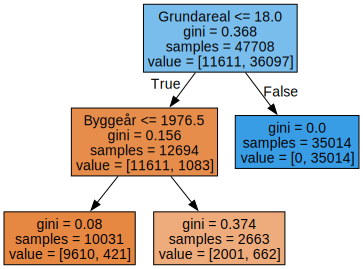

In [20]:
# Deler dataen op i det vi gerne vil lære at forudsige (truth_data) og resten (input_data)
variabler       = data.columns
input_variabler = variabler[(variabler != forudsig)]
input_data      = data[input_variabler]
truth_data      = data[forudsig]


# Her bliver modellen trænet på data
if classification == True:
   estimator = DecisionTreeClassifier(max_depth=DT_N_lag, min_samples_leaf = 20,random_state=42)

if regression == True:
   estimator = DecisionTreeRegressor(max_depth=DT_N_lag, min_samples_leaf = 20,random_state=42)

estimator.fit(input_data, truth_data)   # Dette er den "magiske" linje - her optimerer Machine Learning algoritmen sine interne vægte til at give bedste svar

# laver visuel graf af træet
graph = Source(tree.export_graphviz(estimator, out_file=None,
   feature_names=input_data.columns,              # Labels bliver brugt som overskrifter
   filled=True,                       # Farver noder efter pris - højere pris, mørkere farve
   max_depth=50))                      # Hvor mange lag den skal vise i grafen

print("Max dybde af træet:", estimator.get_depth()) 
display(SVG(graph.pipe(format='svg')))


### Ideer til at lege rundt med koden

- Inspicer træet. Forstår du/I, hvad de forskellige tal betyder?
  Hvilken type bolig passer flest eksempler ned i, i lag 2? Hvad er algoritmens bud på deres pris (dvs. gennemsnitsprisen)?
- Prøv at ændre på hvor mange lag der er i træet fra 2 til 3.
  Hvilken parameter bliver brugt oftest til at opdele data? Tror du/I at den så er den vigtigste parameter?
  Kan du/I ud fra træet sige mere generelt hvilke parametre der betyder mest for prisen? Hvilke betyder mindst?
- Prøv at træne træet på en anden parameter ved at ændre "forudsig" - Er nogen parameter nemmere at forudsige end andre? Hvorfor?